<a href="https://colab.research.google.com/github/NataliaBlueCloud/Inband_telemetry_design/blob/main/Cochrams_ofc_example_Milano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages("simmer")
install.packages("SciViews")
install.packages("igraph")
install.packages("reshape2")
install.packages("cowplot")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Rcpp’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘ellipse’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(simmer)
library(SciViews)
library(igraph)
library(readxl)
library(ggplot2)
library(dplyr)
library(reshape2)
library(cowplot)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘dplyr’


The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union


The following object is masked from ‘package:simmer’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
library("googledrive")
if (file.exists("/usr/local/lib/python3.10/dist-packages/google/colab/_ipython.py")){
  install.packages("R.utils")
  library("R.utils")
  library("httr")
  my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check)
  options(rlang_interactive=TRUE)
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’


Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.25.0 (2022-06-12 02:20:02 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following object is masked from ‘package:igraph’:

    hierarchy


The following object is masked from ‘package:simmer’:

    clone


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.12.2 (2022-11-11 22:00:03 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following objects are masked from ‘package:simmer’:

    reset, wrap


The fo

In [4]:
drive_auth(use_oob = TRUE, cache = TRUE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=6f72e828ef1fa1f47b5663b6aea4fb95&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYbWFkdUgzNDJkTzFvOXo1OGs2dVZjYVZpZXYxRmJFTDJzc0NZbW0xSUlfLUpLOVlWbDZIcWpCTzhJZGV4Sl9KdyIsInN0YXRlIjoiNmY3MmU4MjhlZjFmYTFmNDdiNTY2M2I2YWVhNGZiOTUifQ==


In [5]:

drive_download("r_traffic_simulation/func/igraph_function_base.R")
drive_download("r_traffic_simulation/func/igraph_functions.R")
drive_download("r_traffic_simulation/func/general_function_base.R")


File downloaded:

• igraph_function_base.R <id: 1jwogeGEqQc27cQAu8fiA1mF-KI9C41pm>

Saved locally as:

• igraph_function_base.R

File downloaded:

• igraph_functions.R <id: 1Vyg5nvBWPkMzuajVkyFELct6G1qmjMdP>

Saved locally as:

• igraph_functions.R

File downloaded:

• general_function_base.R <id: 18dycCYyQDWXi1dDVj22EoJWkeYQy-9qg>

Saved locally as:

• general_function_base.R



In [6]:
drive_download("r_traffic_simulation/input_files/Metro_topology_full_Milano.xlsx")

File downloaded:

• Metro_topology_full_Milano.xlsx <id: 1qf9aV3AICULgJEx2D98nInZwKnW8D7dn>

Saved locally as:

• Metro_topology_full_Milano.xlsx



In [7]:
source("igraph_function_base.R")
source("igraph_functions.R")
source("general_function_base.R")

In [8]:
file_name <- "Metro_topology_full_Milano.xlsx"

In [9]:
nodes_info <- read_excel(file_name, sheet = 1)
links_info <- read_excel(file_name, sheet = 2)


M/M/1 model

##Input data

In [430]:
set.seed(321)
N = 1250 #packet size (B)
CapacityGbps = 10 #Gbps

In [431]:
create_graph_object <- function(links_info, nodes_info, CapacityGbps,  N = 1250) {
  g <- graph.data.frame(links_info, directed = TRUE, vertices = nodes_info)
  E(g)$capacityGbps <- CapacityGbps
  E(g)$Capacity <- E(g)$capacityGbps*10^9/(8*N)
  E(g)$Distance <- E(g)$distanceKm*4
  E(g)$Definition <- paste0(get.edgelist(g)[,1],"->",get.edgelist(g)[,2])

  return(g)
}


g <- create_graph_object(links_info, nodes_info, CapacityGbps,  N)



In [432]:
################################plot graph
NCOs <- V(g)[c(c(9:20), c(40:44))]

V(g)$Node_Type <- "LCO"
V(g)$Node_Type[NCOs] <- "NCO"
LCOs <- V(g)[V(g)$Node_Type == "LCO"]

V(g)$color <- "gray"
V(g)$color[NCOs] <- "green" # National COs
E(g)$color <- "gray"


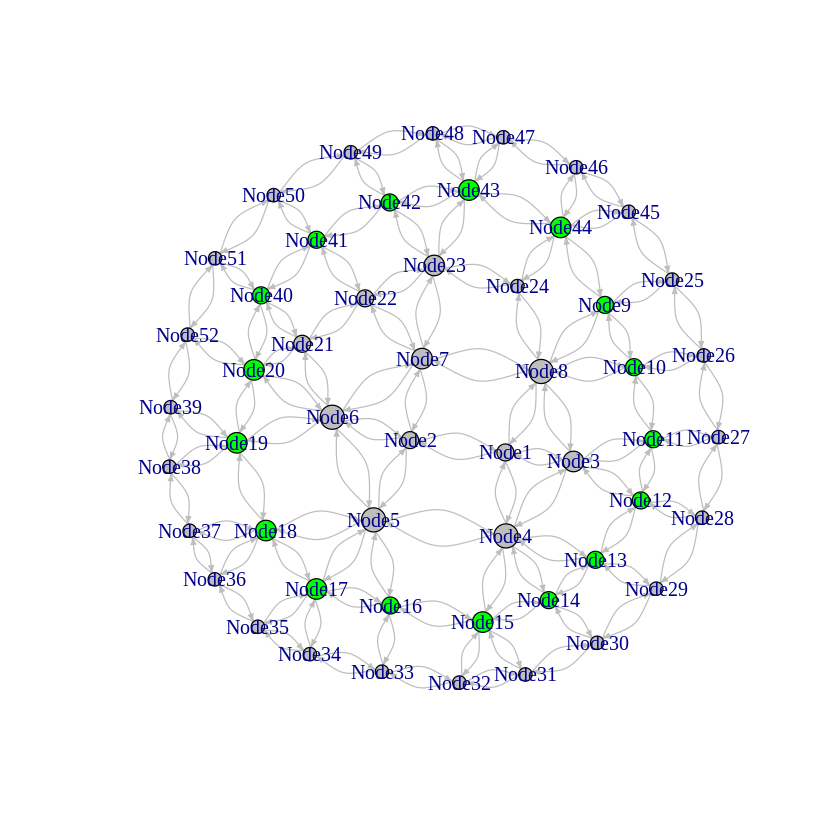

In [433]:
deg <- degree(g, mode="all")
V(g)$size <- 1 + deg*1.3/2
l <- layout.auto(g)
plot(g, edge.arrow.size=.3, vertex.label = V(g)$name, edge.curved=.5, layout=l)


## Queuing and propagation delays

In [434]:
E(g)$Load <- runif(length(E(g)), 0.1, 0.8)


In [435]:

traffic_delays_calc <- function(g) {
  E(g)$Traffic <- E(g)$Capacity*E(g)$Load

  E(g)$Ni = E(g)$Load/(1-E(g)$Load) # average number of packets in each system
  E(g)$Queue_Delay <- ifelse(E(g)$Traffic == 0, 0, E(g)$Ni/E(g)$Traffic)
  E(g)$Prop_Delay <- 5*10^(-6)*E(g)$Distance
  return(g)
}

g <- traffic_delays_calc(g)

#Simulation

Simmulation of 50k packets population

In [436]:
pop_number = 50000

In [437]:
rexp_for_pop <- function(rate){
  return(rexp(n=pop_number,rate))
}

In [438]:

matrx_paths <- array(rep(0, length(NCOs) * length(LCOs) * pop_number), dim = c(length(NCOs), length(LCOs), pop_number))

# Iterate over LCOs
for (i in seq_along(LCOs)) {
  node_LCO <- LCOs[i]

  # Iterate over NCOs
  for (j in seq_along(NCOs)) {
    node_NCO <- NCOs[j]

    # Construct path variable dynamically
    path_var <- paste0("path_", j)
    traffic_path_var <- paste0("traffic_", j)
    delays_var <- paste0("path", j, "_delays")

    # Calculate shortest paths
    path <- shortest_paths(g, node_LCO, node_NCO, weights = NULL, output = "both", algorithm = c("automatic"))
    path <- E(g)[path[["epath"]][[1]]]

    # Calculate delays
    x <- 1/E(g)$Queue_Delay[path]
    traffic_path <- lapply(x, rexp_for_pop)
    delays <- Reduce("+", traffic_path) + sum(E(g)$Prop_Delay[path])

    # Store delays in matrix
    delays_us <- delays * 1e6
    matrx_paths[j, i,] <- delays_us
  }
}



#Results

The results are calculated with the 82 $\mu s$ threshold and a 99% packet percentage, indicating that 99% of sampled packets within a given path must fall below the threshold to fulfill the specified requirement.


In [439]:
threshold_us <- 82
percentage = 0.99

In [440]:
LCOs_thesholds <- rep(threshold_us, length(LCOs))

In [441]:
table_to_df <- function(path_delays, threshold_us){
  df_p <- as.data.frame(table(path_delays < threshold_us, useNA = "always"))
  df_p$Var1 <- as.logical(df_p$Var1)
  df_p$Var1[2] = ifelse(df_p$Var1[1] == 1, 0, 1)
  return(df_p)
}

In [442]:
calc_results <- function(matrx_paths, g, LCOs, NCOs, LCOs_thesholds,n_samples, n_exp, percentage = 1)
{
  matrx_paths_sampled <- array(rep(0, length(NCOs)*length(LCOs)*n_samples), dim = c(length(NCOs), length(LCOs), n_samples))
  packets_below_thr <- array(rep(0, length(NCOs)*length(LCOs)*n_exp), dim = c(length(NCOs), length(LCOs), n_exp))
  results <- array(rep(0, length(LCOs)*n_exp), dim = c(length(LCOs), n_exp))
  percent_below_thr_p1 <- c()
  percent_below_thr_p2 <- c()
  percent_below_thr_p3 <- c()
  for (exp in 1:n_exp)
  {
    for(l in 1:length(LCOs))

    {
      table_res <- c()
      for (n in 1:length(NCOs))
      {
        matrx_paths_sampled[n,l,] = sample( matrx_paths[n,l, ], size=n_samples, replace=F)
        df_p <- table_to_df(matrx_paths_sampled[n,l,], LCOs_thesholds[l])
        df_p <- df_p[order(df_p$Var1),]
        table_res[n] <- df_p$Freq[2]

        packets_below_thr[n,l,exp] <- ifelse(df_p$Freq[2] >= n_samples*percentage , 1, 0) #true or false

      }
    }
  }
  return(packets_below_thr)
}




In [443]:
n_exp <- 1

###Samples size - 5 packets

In [444]:
packets_below_thr_5p <- calc_results(matrx_paths, g, LCOs, NCOs, LCOs_thesholds, n_samples = 5, n_exp, percentage)

###Samples size - 10 packets

In [445]:
packets_below_thr_10p <- calc_results(matrx_paths, g, LCOs, NCOs, LCOs_thesholds, n_samples = 10, n_exp, percentage)

###Samples size - 50 packets

In [446]:
packets_below_thr_50p <- calc_results(matrx_paths, g, LCOs, NCOs, LCOs_thesholds, n_samples = 50, n_exp, percentage)


###Samples size - 100 packets

In [447]:
packets_below_thr_100p <- calc_results(matrx_paths, g, LCOs, NCOs, LCOs_thesholds, n_samples =100, n_exp, percentage)


###Samples size - 400 packets

In [448]:
packets_below_thr_400p <- calc_results(matrx_paths, g, LCOs, NCOs, LCOs_thesholds, n_samples = 400, n_exp, percentage)

###Samples size - 500 packets

In [449]:
packets_below_thr_2500p <- calc_results(matrx_paths, g, LCOs, NCOs, LCOs_thesholds, n_samples = 2500, n_exp, percentage)

###Calculations for the entire population

In [450]:
packets_below_thr_50kp <- calc_results(matrx_paths, g, LCOs, NCOs, LCOs_thesholds, n_samples = 50000, n_exp = 1, percentage)

##Error FP and FN calculations

In [451]:
calc_error <- function(max_1, max_2, n_exp){
  FN <- c()
  FP <- c()
  percentage_FN <- c()
  percentage_FP <- c()


  for (exp in 1:n_exp){
    FN[exp] <- sum(max_1[,,exp] == FALSE & max_2[,,1]  == TRUE)
    FP[exp] <- sum(max_1[,,exp] == TRUE & max_2[,,1]  == FALSE)
    total_elements <- length(max_1[,,exp])

    # Calculate percentages
    percentage_FP[exp] <- (FP[exp] / total_elements) * 100
    percentage_FN[exp] <- (FN[exp] / total_elements) * 100


  }
  # Display the results
  cat("False Positives:", mean(FP), "\n")
  cat("False Negatives:", mean(FN), "\n")
  cat("Percentage of False Positives:",  mean(percentage_FP), "%\n")
  cat("Percentage of False Negatives:",  mean(percentage_FN), "%\n")
  return(list(percentage_FP, percentage_FN))
}

In [452]:
cat("5 packets: \n")
c(percentage_FP_5p, percentage_FN_5p) := calc_error(packets_below_thr_5p, packets_below_thr_50kp, n_exp)
cat("10 packets: \n")
c(percentage_FP_10p, percentage_FN_10p) := calc_error(packets_below_thr_10p, packets_below_thr_50kp, n_exp)
cat("50 packets: \n")
c(percentage_FP_50p, percentage_FN_50p) := calc_error(packets_below_thr_50p, packets_below_thr_50kp, n_exp)
cat("100 packets: \n")
c(percentage_FP_100p, percentage_FN_100p) := calc_error(packets_below_thr_100p, packets_below_thr_50kp, n_exp)
cat("400 packets: \n")
c(percentage_FP_400p, percentage_FN_400p) := calc_error(packets_below_thr_400p, packets_below_thr_50kp, n_exp)
cat("2500 packets: \n")
c(percentage_FP_2500p, percentage_FN_2500p) := calc_error(packets_below_thr_2500p, packets_below_thr_50kp, n_exp)


5 packets: 
False Positives: 63 
False Negatives: 2 
Percentage of False Positives: 10.58824 %
Percentage of False Negatives: 0.3361345 %
10 packets: 
False Positives: 45 
False Negatives: 1 
Percentage of False Positives: 7.563025 %
Percentage of False Negatives: 0.1680672 %
50 packets: 
False Positives: 12 
False Negatives: 10 
Percentage of False Positives: 2.016807 %
Percentage of False Negatives: 1.680672 %
100 packets: 
False Positives: 7 
False Negatives: 0 
Percentage of False Positives: 1.176471 %
Percentage of False Negatives: 0 %
400 packets: 
False Positives: 3 
False Negatives: 3 
Percentage of False Positives: 0.5042017 %
Percentage of False Negatives: 0.5042017 %
2500 packets: 
False Positives: 0 
False Negatives: 1 
Percentage of False Positives: 0 %
Percentage of False Negatives: 0.1680672 %


#Heatmaps

Heatmaps of results, where each path satisfies (or not) the threshold from each LCO to each NCO across
the scenario of the sample size of 5 packets: the red points indicate the paths
with error

In [453]:


plot_heatmap <- function(matrix_1, matrix_2, LCOs, NCOs, error_colour = "red"){
  row_names <- paste0("Node_", NCOs)
  col_names <- paste0("Node_", LCOs)
  colnames(matrix_1) <- col_names
  rownames(matrix_1) <- row_names
  colnames(matrix_2) <- col_names
  rownames(matrix_2) <- row_names


  df1 <- reshape2::melt(matrix_1[,,1])
  df2 <- reshape2::melt(matrix_2[,,1])

  # Combine data frames
  df <- cbind(df1, Value2 = df2$value)

  # Create a column indicating whether values are the same or not
  df$SameValue <- df$value == df$Value2

  ggplot(df, aes(x = Var2, y = Var1, fill = as.factor(value))) +
    geom_tile() +
    geom_point(data = subset(df, !SameValue), aes(color = as.factor(!SameValue)), shape = 16, size = 2, fill = error_colour) +
    scale_fill_manual(values = c("gray45", "white"), name = "Path satisfies thr.", labels = c("FALSE", "TRUE")) +
    scale_color_manual(values = c(error_colour, "white"), name = "Errors", labels = c("error", "no errors")) +
    labs(title = "",
        x = "LCOs",
        y = "NCOs") +
    theme_minimal() +
    guides(fill = guide_legend(title = "Path satisfies thr."),
          color = guide_legend(title = "Errors")) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))  # Rotate x-axis labels by 90 degrees
}



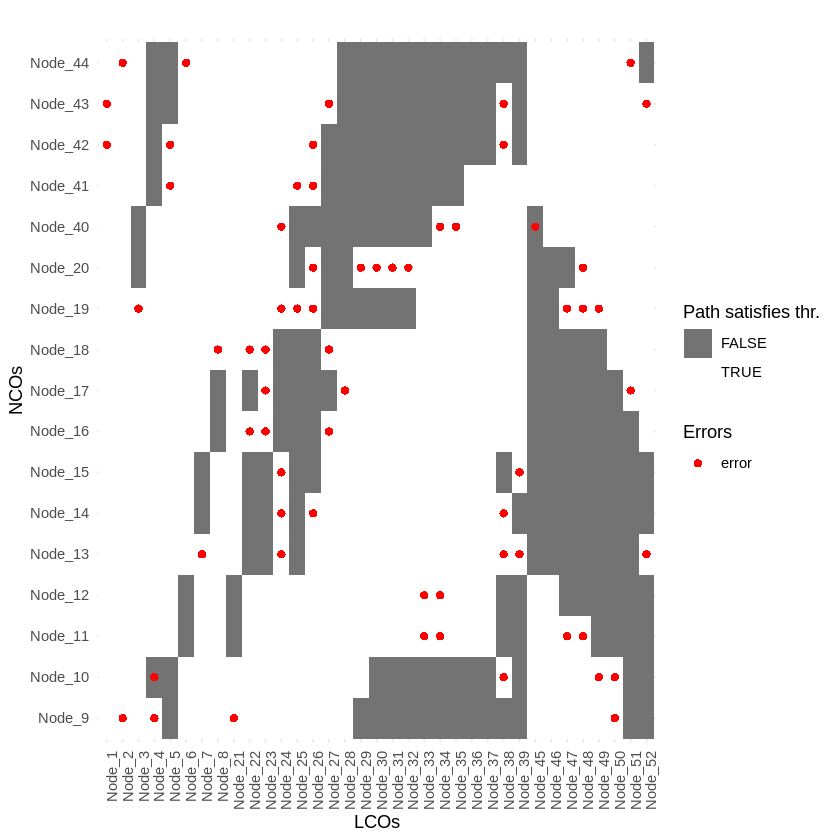

In [454]:
plot_heatmap(packets_below_thr_5p, packets_below_thr_50kp, LCOs, NCOs)

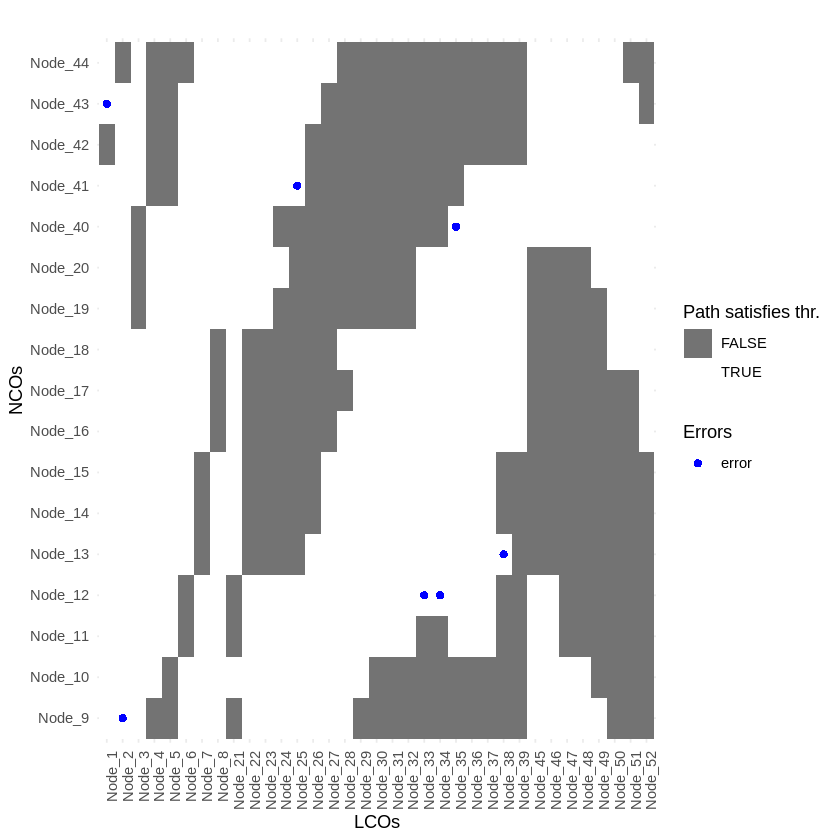

In [455]:
plot_heatmap(packets_below_thr_100p, packets_below_thr_50kp, LCOs, NCOs, error_colour = "blue")


Heatmap of 2500 packets, the blue points indicate the paths
with error

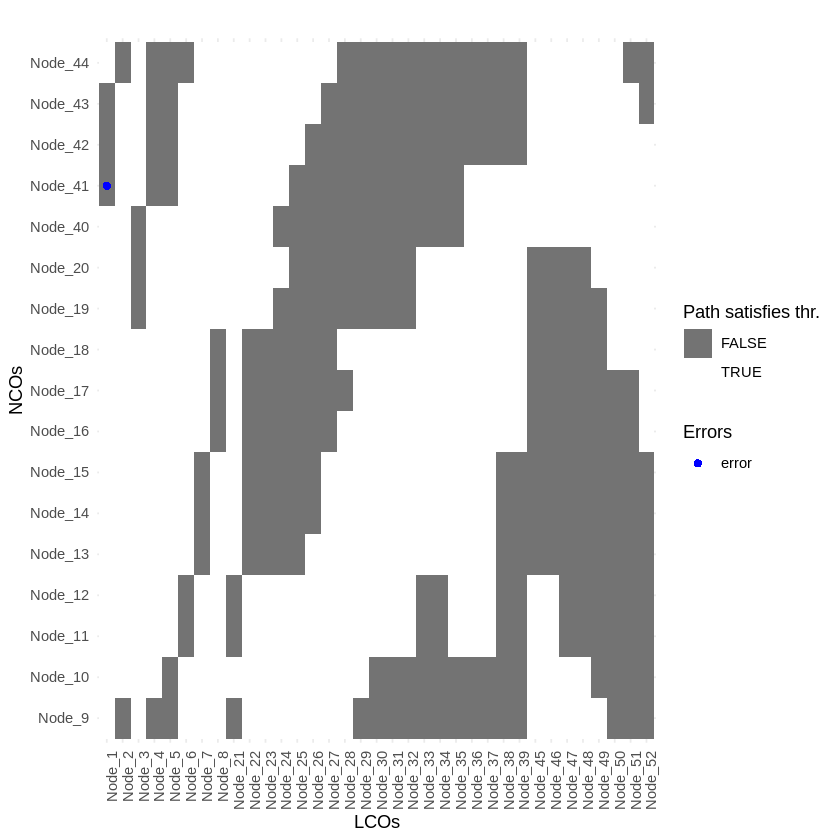

In [456]:
plot_heatmap(packets_below_thr_2500p, packets_below_thr_50kp, LCOs, NCOs, error_colour = "blue")
